In [1]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load as zip if too slow to upload to colab

In [2]:
!unzip train.csv.zip 

Archive:  train.csv.zip
  inflating: train.csv               


# Train-Val-Test split

In [3]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('train.csv')
df = df.drop('id', axis = 1)

df = df.sample(frac=1, random_state=42).reset_index().drop('index', axis = 1)
train = df[:int(len(df)*0.3)]
val = df[int(len(df)*0.3):int(len(df)*0.32)]
test = df[int(len(df)*0.32):int(len(df)*0.34)]

In [4]:
print(len(val))

3191


# Preprocessing

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)      ### conversion of contraction words to expanded words
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)                                                 ### removing non-word characters

    text = re.sub(r'fck', 'fuck', text)
    text = re.sub(r'a$$', 'ass', text)
    text = re.sub(r'@', 'at', text)
    text = re.sub(r'wikipedia:[^\s]+',' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub('(utc)', ' ' ,text)
    text = re.sub(' u ', ' you ' ,text)

    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-letter values(Except single quotes)
    text = re.sub('\s+', ' ', text)

    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])    ### Stopwords removal
    return text

#Conv2D for classification : 
Article utilisé: https://arxiv.org/pdf/1408.5882.pdf

In [7]:
!pip install torchtext==0.6.0;

import torch
import torchtext
from torchtext.data import Field
from torch import nn
# from torch.utils.data import DataLoader
import spacy

     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 1.2MB 25.1MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


## Vocabulary

In [8]:
# !python -m spacy download en
spacy_eng = spacy.load("en")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)
            
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        word_list = ' '.join(sentence_list)
        for word in self.tokenizer_eng(word_list):
            if word not in frequencies:
                frequencies[word] = 1

            else:
                frequencies[word] += 1

            if frequencies[word] == self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


# Dataset

In [9]:
from torch.utils.data import DataLoader, Dataset

class CommentDataset(Dataset):
    def __init__(self, df, columns_list, transform=None, freq_threshold=5):
        """
        columns_list: a list of targets we want to model (ie ['toxic', 'obscene_toxic'])  
        transform: function that does preprocessing on our data (usually it is a torchvision function)
        """
        self.df = df
        self.transform = transform

        # Get comment_text and the sentiment targets
        self.comment_text = self.df["comment_text"]
        self.targets = self.df[columns_list]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.preprocessed_text = self.comment_text.apply(transform)
        self.vocab.build_vocabulary(self.preprocessed_text.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        targets = self.targets.iloc[index].values
        comment_text = self.comment_text.iloc[index]

        # if self.transform is not None:
        #     img = self.transform(img)

        numericalized_comment = [self.vocab.stoi["<SOS>"]]
        numericalized_comment += self.vocab.numericalize(comment_text)
        numericalized_comment.append(self.vocab.stoi["<EOS>"])

        return torch.tensor(numericalized_comment), torch.tensor(targets)

In [10]:
tgts = ['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
dataset = CommentDataset(train, tgts, transform=clean_text, freq_threshold=3)

# Initialize embedding matrix using GloVe-Twitter-50

In [12]:
import gensim
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

# Download the "glove-twitter-50" embeddings
glove = gensim.downloader.load('glove-twitter-50')
emb_dim = 50

matrix_len = len(dataset.vocab)
weights_matrix = np.zeros((matrix_len, emb_dim))
words_found = 0

for i, word in enumerate(dataset.vocab.itos.values()):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

print(words_found)

[==================================================] 100.0% 199.5/199.5MB downloaded
26143


# Create model architecture

In [13]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim


class CNN_Classif(nn.Module):
    def __init__(self, weights_matrix, params, p = 0.5):
        super(CNN_Classif, self).__init__()
        # Embedding layer using glove
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, non_trainable = True)
        
        #define dropout rate
        self.dropout = nn.Dropout(p)

        #define relu 
        self.relu = nn.ReLU()

        # CNN parameters definition
        # Kernel sizes
        self.kernel_3 = 3
        self.kernel_4 = 4
        self.kernel_5 = 5
        
        # Output size for each convolution
        self.cnn_out_size = params['cnn_out_size']
        # Number of strides for each convolution
        self.stride = params['stride']
        self.output = params['output']
        
        # Convolution layers definition
        # input  (N, C_{\text{in}}, H, W)(N,Cin,H,W) 

        self.conv_3 = nn.Conv2d(in_channels=1, out_channels=self.cnn_out_size, kernel_size = (self.kernel_3, embedding_dim), stride = self.stride)
        self.conv_4 = nn.Conv2d(in_channels=1, out_channels=self.cnn_out_size, kernel_size = (self.kernel_4, embedding_dim), stride = self.stride)
        self.conv_5 = nn.Conv2d(in_channels=1, out_channels=self.cnn_out_size, kernel_size = (self.kernel_5, embedding_dim), stride = self.stride)


        self.in_features_fc = 3 * 100
        # Fully connected layer definition
        self.fc = nn.Linear(self.in_features_fc, self.output)


    def forward(self, inp):
        vec = self.embedding(inp)
        vec = vec.unsqueeze(dim=1).permute(2,1,0,3)
        cnn3 = self.conv_3(vec).squeeze(-1)
        cnn4 = self.conv_4(vec).squeeze(-1)
        cnn5 = self.conv_5(vec).squeeze(-1)
        pool3 = torch.max(cnn3, dim = 2)[0]
        pool4 = torch.max(cnn4, dim = 2)[0]
        pool5 = torch.max(cnn5, dim = 2)[0]
        concat = torch.cat([pool3, pool4, pool5], dim = 1)
        output = self.fc(concat)
        return output


# Utils: Padding sequences in batch and DataLoader

In [14]:
from torch.nn.utils.rnn import pad_sequence  # pad batch


# class that pads sequences of sentences in the same batch
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        
        targets = [item[1].unsqueeze(0) for item in batch]
        targets = torch.cat(targets, dim=0)
        comments = [item[0] for item in batch]
        comments = pad_sequence(comments, batch_first=False, padding_value=self.pad_idx)

        return comments, targets




def get_loader(dataset, batch_size=16, num_workers=2, shuffle=False, pin_memory=True):

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn = MyCollate(pad_idx)
    )

    return loader

# Data loader taking too much time, had to build similar class
def poor_mans_dataloader(dataset, batch_size = 32):
    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate = MyCollate(pad_idx)
    batch = []
    ind = np.random.randint(0,len(dataset), batch_size)
    for i in ind:
        batch.append(dataset_train[i])
    return collate(batch)


# Training hyper-parameters

In [16]:
from torch.utils.tensorboard import SummaryWriter


num_epochs = 20
learning_rate = 0.001
batch_size = 32

# Model hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Tensor board
writer = SummaryWriter()
step = 0


params = {'cnn_out_size': 100 , 'stride': 3, 'output': 6}
cnn = CNN_Classif(weights_matrix, params = params, p = 0.5).to(device)


w = torch.Tensor(1/np.array(train[['toxic', 'severe_toxic', 'obscene', 'threat',
    'insult', 'identity_hate']].sum(axis = 0))).to(device)
print(w)
criterion = torch.nn.BCEWithLogitsLoss(w)

tensor([0.0002, 0.0021, 0.0004, 0.0074, 0.0004, 0.0023], device='cuda:0')


In [17]:
def get_accuracy(output, y, by_cat = False):
    if by_cat:
        return torch.mean(((torch.sigmoid(output) > 0.5) == (y > 0.5)).float(), axis = 0)
    else:
        return torch.mean(((torch.sigmoid(output) > 0.5) == (y > 0.5)).float())

In [18]:
!mkdir model_state

# Training

In [19]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)


tgts = ['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']

dataset_train = CommentDataset(train, tgts, transform=clean_text)
dataset_val = CommentDataset(val, tgts, transform=clean_text)

loader_train = get_loader(dataset_train, batch_size)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

best_val_loss = 10000
for epoch in range(num_epochs):
    print(f'Epoch {epoch} / {num_epochs}')

    # checkpoint = {'state_dict':cnn.state_dict(), 'optimizer':optimizer.state_dict()}

    # save_checkpoint(checkpoint)

    #val loss
    val_batch = poor_mans_dataloader(dataset_val)
    v_inp = val_batch[0].to(device)
    v_tgt = val_batch[1].to(device)

    # Code running too slowly, had to decrease how many batches go through in each epoch
    for i in range(10):
        train_batch = poor_mans_dataloader(dataset_train, batch_size)
        
        inp_data = train_batch[0].to(device)
        targets = train_batch[1].to(device)

        output = cnn(inp_data)

        optimizer.zero_grad()
        targets = targets.type_as(output)

        loss = criterion(output, targets)
        train_loss_list.append(loss)

        train_acc = get_accuracy(output, targets)
        train_acc_list.append(train_acc)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(cnn.parameters(), max_norm = 1)
        optimizer.step()

        v_output = cnn(v_inp)

        #output shape (tgt_len ,b_size, output_dim)

        v_tgt = v_tgt.type_as(v_output)
        val_loss = criterion(v_output, v_tgt)
        val_loss_list.append(val_loss)

        val_acc = get_accuracy(v_output, v_tgt)
        val_acc_list.append(val_acc)


        step += 1

    if val_loss < best_val_loss:
        print('Saving best model so far ..')
        torch.save(cnn.state_dict(), '/model_state')
        best_val_loss = val_loss

    print(f'Loss training {loss}, Loss validation {val_loss}, Validation accuracy : {val_acc}')

writer.close()

Epoch 0 / 20
Saving best model so far ..
Loss training 0.00012728440924547613, Loss validation 0.0002512533392291516, Validation accuracy : 0.9635416865348816
Epoch 1 / 20
Saving best model so far ..
Loss training 5.1910516049247235e-05, Loss validation 0.0001241081627085805, Validation accuracy : 0.90625
Epoch 2 / 20
Saving best model so far ..
Loss training 0.00015630494453944266, Loss validation 9.791215416043997e-05, Validation accuracy : 0.953125
Epoch 3 / 20
Saving best model so far ..
Loss training 1.2675328434852418e-05, Loss validation 2.9848139092791826e-05, Validation accuracy : 0.984375
Epoch 4 / 20
Loss training 0.00034209302975796163, Loss validation 0.00012455919932108372, Validation accuracy : 0.9375
Epoch 5 / 20
Loss training 2.872744335036259e-05, Loss validation 3.5529432352632284e-05, Validation accuracy : 0.9739583730697632
Epoch 6 / 20
Saving best model so far ..
Loss training 0.00012108115333830938, Loss validation 2.197283538407646e-05, Validation accuracy : 0.9

Text(0.5, 1.0, 'Training/Val global accuracy  per epochs')

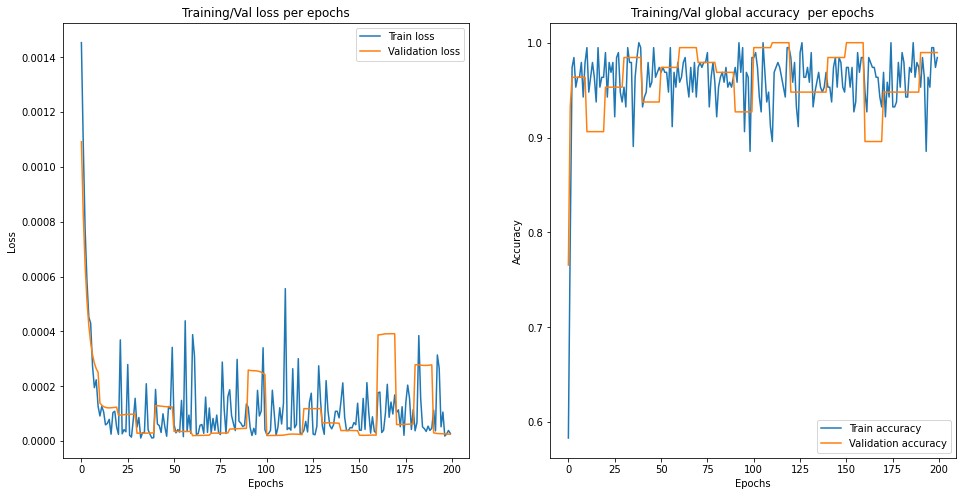

In [20]:
plt.subplots(1, 2, figsize = (16,8))
plt.subplot(121)
plt.plot(train_loss_list, label = 'Train loss')
plt.plot(val_loss_list, label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Val loss per epochs')
plt.subplot(122)
plt.plot(train_acc_list, label = 'Train accuracy')
plt.plot(val_acc_list, label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training/Val global accuracy  per epochs')

# Loading best model state and computing accuracy scores on test

In [22]:
# Model class must be defined somewhere
best_state = torch.load('/model_state')
cnn_best = CNN_Classif(weights_matrix, params = params, p = 0.5).to(device)
cnn_best.load_state_dict(best_state)
cnn_best.eval()

dataset_test = CommentDataset(test, tgts, transform=clean_text)
test_batch = poor_mans_dataloader(dataset_test, 128)
inp_data = test_batch[0].to(device)
targets = test_batch[1].to(device)
output = cnn_best(inp_data)
targets = targets.type_as(output)
test_acc = get_accuracy(output, targets, True)
print(test_acc)

tensor([0.8906, 0.9922, 0.9609, 1.0000, 0.9531, 0.9844], device='cuda:0')
